In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

import os
import numpy as np
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image

import requests
from io import BytesIO

from glob import glob 

import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [3]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [4]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_20656\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [5]:
bp_track_media = pd.read_csv('data/bp_track_media.csv')

In [6]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [7]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

In [8]:
# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'genre_name']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [9]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [10]:
def load_audio_from_url(df, sample_uuid_column):
    failed_samples = []
    saved_file_paths = []
    
    base_url = "https://geo-samples.beatport.com/track/"
    save_directory = "audio_files"
    os.makedirs(save_directory, exist_ok=True)
    
    for sample_uuid in tqdm(df[sample_uuid_column]):
        # Construct full audio URL
        audio_url = f"{base_url}{sample_uuid}.LOFI.mp3"
        save_path = os.path.join(save_directory, f"{sample_uuid}.mp3")
        
        # Check if the file already exists
        if os.path.exists(save_path):
            saved_file_paths.append(save_path)
            continue  # Skip the download if file already exists
        
        try:
            # Send a request to download the audio file
            response = requests.get(audio_url)
            response.raise_for_status()  # Raise an exception for failed requests

            # Save the downloaded audio file locally
            with open(save_path, 'wb') as f:
                f.write(response.content)
            
            # Append the file path to the saved file paths list
            saved_file_paths.append(save_path)
        
        except Exception as e:
            failed_samples.append(sample_uuid)  # Add the sample_uuid to the failed list
    
    return saved_file_paths, failed_samples

In [11]:
def extract_mfcc(audio_file_path, n_mfcc=13, max_length=2500):
    try:
        # Load the audio file using librosa
        signal, sample_rate = librosa.load(audio_file_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

        # Pad or truncate MFCCs to a fixed length
        if mfccs.shape[1] < max_length:
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs_padded = mfccs[:, :max_length]

        return mfccs_padded
    
    except Exception as e:
        print(f"Error processing audio file {audio_file_path}: {e}")
        return None

In [12]:
saved_file_paths, failed_sample_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

100%|██████████| 1000/1000 [00:00<00:00, 1024.01it/s]


In [13]:
# Initialize lists to hold MFCC features and genres
mfcc_features = []
genres = []

# Iterate over all saved audio files (from the load_audio_from_url function)
for audio_file_path in tqdm(saved_file_paths):
    # Extract the sample_uuid from the file path (assuming the file name is in the form 'sample_uuid.mp3')
    sample_uuid = os.path.basename(audio_file_path).replace('.mp3', '')  # Extract just the sample_uuid

    # Find the corresponding genre in the DataFrame
    genre = sampled_data.loc[sampled_data['sample_uuid'] == sample_uuid, 'genre_name'].values
    if len(genre) == 0:
        print(f"Genre not found for {sample_uuid}, skipping.")
        continue

    genre = genre[0]  # Extract the genre value

    # Extract MFCC features
    mfccs = extract_mfcc(audio_file_path)

    # Only append if MFCC extraction was successful
    if mfccs is not None:
        mfcc_features.append(mfccs)  # Append MFCC features
        genres.append(genre)  # Append the corresponding genre

# Convert the lists of MFCC features and genres into NumPy arrays
mfcc_features = np.array(mfcc_features)
genres = np.array(genres)

print(f"Extracted MFCC features shape: {mfcc_features.shape}")
print(f"Genre labels shape: {genres.shape}")

100%|██████████| 994/994 [06:39<00:00,  2.49it/s]


Extracted MFCC features shape: (994, 13, 2500)
Genre labels shape: (994,)


In [14]:
scaler = StandardScaler()

# Reshape the MFCC features to 2D array for scaling (before reshaping back)
mfcc_reshaped = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Fit the scaler to the data and transform it
mfcc_normalized = scaler.fit_transform(mfcc_reshaped)

# Reshape back to the original shape after scaling
mfcc_normalized = mfcc_normalized.reshape(mfcc_features.shape)

In [15]:
label_encoder = LabelEncoder()
genres_encoded = label_encoder.fit_transform(genres)

# One-hot encode the genres for the classification task
genres_one_hot = to_categorical(genres_encoded)

In [16]:
# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc_normalized, genres_one_hot, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (795, 13, 2500), (795, 30)
Test set shape: (199, 13, 2500), (199, 30)


In [17]:
# Reshape MFCC features for the CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Number of genres (output classes)
num_classes = y_train.shape[1]

In [18]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

c:\Users\Shank\anaconda3\envs\dsenv3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 2498, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 1249, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 1247, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 623, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,103,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,126,430 (19.56 MB)

 Trainable params: 5,126,430 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Define the path where the best model will be saved
model_checkpoint_path = 'best_model_audio.keras'

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(X_train_cnn, y_train, epochs=100, batch_size=15, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluate the best model on the test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.0863 - loss: 3.9462 - val_accuracy: 0.1508 - val_loss: 2.9828 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.1059 - loss: 3.0254 - val_accuracy: 0.1256 - val_loss: 2.9886 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.1554 - loss: 2.9435 - val_accuracy: 0.1206 - val_loss: 2.9598 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.1250 - loss: 2.8987 - val_accuracy: 0.1608 - val_loss: 2.9199 - learning_rate: 0.0010
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.1633 - loss: 2.8136 - val_accuracy: 0.1608 - val_loss: 2.8812 - learning_rate: 0.0010
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.1753 - loss: 2.7493 - val_accuracy: 0.1357 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.1871 - loss: 2

_____________________

# Manual Grouping

In [20]:
genre_mapping = {
    # House Group
    'House': 'House',
    'Tech House': 'House',
    'Deep House': 'House',
    'Progressive House': 'House',
    'Funky House': 'House',
    'Jackin House': 'House',
    'Afro House': 'House',
    'Bass House': 'House',

    # Techno Group
    'Techno (Peak Time / Driving)': 'Techno',
    'Techno (Raw / Deep / Hypnotic)': 'Techno',
    'Minimal / Deep Tech': 'Techno',
    'Melodic House & Techno': 'Techno',
    'Hard Techno': 'Techno',

    # Trance Group
    'Trance (Main Floor)': 'Trance',
    'Psy-Trance': 'Trance',
    'Trance (Raw / Deep / Hypnotic)': 'Trance',

    # Bass Music Group
    'Drum & Bass': 'Bass Music',
    'Dubstep': 'Bass Music',
    '140 / Deep Dubstep / Grime': 'Bass Music',
    'Trap / Wave': 'Bass Music',
    'Breaks / Breakbeat / UK Bass': 'Bass Music',
    'Bass / Club': 'Bass Music',
    'UK Garage / Bassline': 'Bass Music',

    # Hard Dance & Hardcore Group
    'Hard Dance / Hardcore': 'Hard Dance & Hardcore',

    # Dance/Pop Group
    'Mainstage': 'Dance/Pop',
    'Dance / Electro Pop': 'Dance/Pop',
    'Nu Disco / Disco': 'Dance/Pop',

    # Downtempo & World Group
    'Organic House / Downtempo': 'Downtempo & World',
    'Amapiano': 'Downtempo & World',

    # Experimental & Indie Group
    'Electronica': 'Experimental & Indie',
    'Indie Dance': 'Experimental & Indie',
    'Electro (Classic / Detroit / Modern)': 'Experimental & Indie'
}

In [21]:
# Assuming your DataFrame is df and it has a column 'genre_name'
bp_genre['broad_genre'] = bp_genre['genre_name'].map(genre_mapping)

In [22]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

In [23]:
# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'broad_genre']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [24]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [25]:
saved_file_paths, failed_sample_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

100%|██████████| 1000/1000 [00:00<00:00, 2477.85it/s]


In [26]:
mfcc_features = []
genres = []

# Iterate over all saved audio files (from the load_audio_from_url function)
for audio_file_path in tqdm(saved_file_paths):
    # Extract the sample_uuid from the file path (assuming the file name is in the form 'sample_uuid.mp3')
    sample_uuid = os.path.basename(audio_file_path).replace('.mp3', '')  # Extract just the sample_uuid

    # Find the corresponding genre in the DataFrame
    genre = sampled_data.loc[sampled_data['sample_uuid'] == sample_uuid, 'broad_genre'].values
    if len(genre) == 0:
        print(f"Genre not found for {sample_uuid}, skipping.")
        continue

    genre = genre[0]  # Extract the genre value

    # Extract MFCC features
    mfccs = extract_mfcc(audio_file_path)

    # Only append if MFCC extraction was successful
    if mfccs is not None:
        mfcc_features.append(mfccs)  # Append MFCC features
        genres.append(genre)  # Append the corresponding genre

# Convert the lists of MFCC features and genres into NumPy arrays
mfcc_features = np.array(mfcc_features)
genres = np.array(genres)

print(f"Extracted MFCC features shape: {mfcc_features.shape}")
print(f"Genre labels shape: {genres.shape}")

100%|██████████| 994/994 [05:48<00:00,  2.85it/s]


Extracted MFCC features shape: (994, 13, 2500)
Genre labels shape: (994,)


In [27]:
scaler = StandardScaler()

# Reshape the MFCC features to 2D array for scaling (before reshaping back)
mfcc_reshaped = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Fit the scaler to the data and transform it
mfcc_normalized = scaler.fit_transform(mfcc_reshaped)

# Reshape back to the original shape after scaling
mfcc_normalized = mfcc_normalized.reshape(mfcc_features.shape)

In [28]:
label_encoder = LabelEncoder()
genres_encoded = label_encoder.fit_transform(genres)

# One-hot encode the genres for the classification task
genres_one_hot = to_categorical(genres_encoded)

In [29]:
# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc_normalized, genres_one_hot, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (795, 13, 2500), (795, 8)
Test set shape: (199, 13, 2500), (199, 8)


In [30]:
# Reshape MFCC features for the CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Number of genres (output classes)
num_classes = y_train.shape[1]

In [31]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

c:\Users\Shank\anaconda3\envs\dsenv3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 11, 2498, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 1249, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 1247, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 623, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 39872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,103,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,123,592 (19.54 MB)

 Trainable params: 5,123,592 (19.54 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Define the path where the best model will be saved
model_checkpoint_path = 'best_model_audio_manuel_grouping.keras'

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(X_train_cnn, y_train, epochs=100, batch_size=15, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluate the best model on the test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.2410 - loss: 2.5753 - val_accuracy: 0.3668 - val_loss: 1.7502 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.3195 - loss: 1.8444 - val_accuracy: 0.3668 - val_loss: 1.7950 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.3056 - loss: 1.7687 - val_accuracy: 0.3668 - val_loss: 1.7273 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.3441 - loss: 1.7172 - val_accuracy: 0.3568 - val_loss: 1.7258 - learning_rate: 0.0010
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.3972 - loss: 1.6134 - val_accuracy: 0.3618 - val_loss: 1.7213 - learning_rate: 0.0010
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.4000 - loss: 1.6005 - val_accuracy: 0.3568 - val_loss: 1.6983 - learning_rate: 0.0010
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.4044 - loss: 1.

__________

# KMeans Clustering

In [33]:
sampled_data = bp_media.sample(n=1000, random_state=42)
saved_file_paths, failed_sample_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

100%|██████████| 1000/1000 [00:00<00:00, 2327.49it/s]


In [34]:
def extract_chroma(audio_file, sr=16000, max_length=1600):
    signal, sample_rate = librosa.load(audio_file, sr=sr)
    chroma = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    if chroma.shape[1] < max_length:
        chroma = np.pad(chroma, ((0, 0), (0, max_length - chroma.shape[1])), mode='constant')
    else:
        chroma = chroma[:, :max_length]
    return chroma

In [35]:
def extract_mfcc(audio_file, n_mfcc=13, sr=16000, max_length=1600):
    signal, sample_rate = librosa.load(audio_file, sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]
    return mfcc

In [36]:
combined_features = []

for audio_file in saved_file_paths:  # saved_file_paths is your list of file paths
    try:
        # Extract Chroma and MFCC
        chroma = extract_chroma(audio_file)
        mfcc = extract_mfcc(audio_file)
        
        # Concatenate Chroma and MFCC features
        combined = np.concatenate((chroma, mfcc), axis=0)
        
        combined_features.append(combined)
    
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

# Convert to NumPy array for further processing
combined_features_np = np.array(combined_features)

# Reshape to make it 2D (n_samples, n_features)
combined_features_np = combined_features_np.reshape(combined_features_np.shape[0], -1)

c:\Users\Shank\anaconda3\envs\dsenv3\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [37]:
print(f"Shape of Chroma features: {combined_features_np.shape}")

Shape of Chroma features: (994, 40000)


In [38]:
scaler = StandardScaler()

audio_data = scaler.fit_transform(combined_features_np)

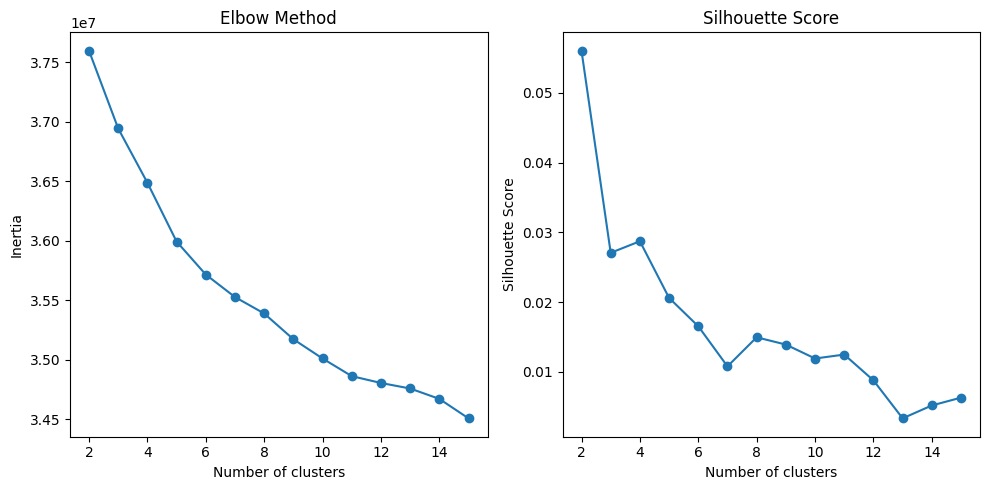

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# List to store inertia values for the Elbow Method and Silhouette Scores
inertia = []
sil_scores = []

# Range of cluster numbers to test (2 to 15 clusters, for example)
cluster_range = range(2, 16)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(audio_data)
    
    # Append the inertia (sum of squared distances) for the Elbow Method
    inertia.append(kmeans.inertia_)
    
    # Predict cluster labels and calculate silhouette score
    cluster_labels = kmeans.predict(audio_data)
    sil_score = silhouette_score(audio_data, cluster_labels)
    sil_scores.append(sil_score)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

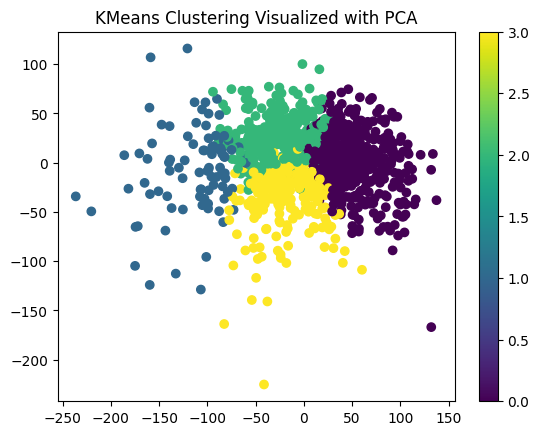

In [40]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(audio_data)

# Apply KMeans on the original feature list
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(audio_data)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('KMeans Clustering Visualized with PCA')
plt.show()

_____________

# Agglomerative Clustering

In [41]:
from sklearn.cluster import AgglomerativeClustering

In [42]:
# List to store silhouette scores for different number of clusters
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_clusters = agglo.fit_predict(audio_data)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(audio_data, agglo_clusters)
    sil_scores.append(sil_score)

# Plot the silhouette scores for different cluster numbers
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

KeyboardInterrupt: 

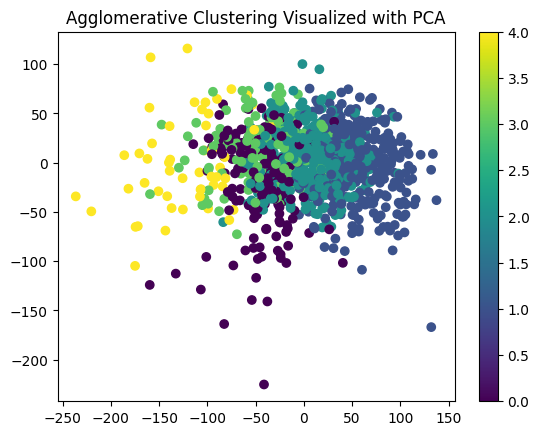

In [42]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(audio_data)

# Apply KMeans on the original feature list
agglo = AgglomerativeClustering(n_clusters=5)
clusters = agglo.fit_predict(audio_data)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('Agglomerative Clustering Visualized with PCA')
plt.show()

________

# GMM Clustering

In [43]:
from sklearn.mixture import GaussianMixture

In [44]:
# Lists to store scores for different numbers of clusters
sil_scores = []
aic_scores = []
bic_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)  # Try different numbers of clusters

for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    
    # Fit the GMM model
    gmm_clusters = gmm.fit_predict(audio_data)
    
    # Calculate and append the silhouette score
    sil_score = silhouette_score(audio_data, gmm_clusters)
    sil_scores.append(sil_score)
    
    # Append AIC and BIC scores
    aic_scores.append(gmm.aic(audio_data))
    bic_scores.append(gmm.bic(audio_data))

# Plot the results
plt.figure(figsize=(15, 5))

# Plot Silhouette Scores
plt.subplot(1, 3, 1)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# Plot AIC Scores
plt.subplot(1, 3, 2)
plt.plot(cluster_range, aic_scores, marker='o', label='AIC', color='orange')
plt.title('AIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('AIC Score')

# Plot BIC Scores
plt.subplot(1, 3, 3)
plt.plot(cluster_range, bic_scores, marker='o', label='BIC', color='green')
plt.title('BIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


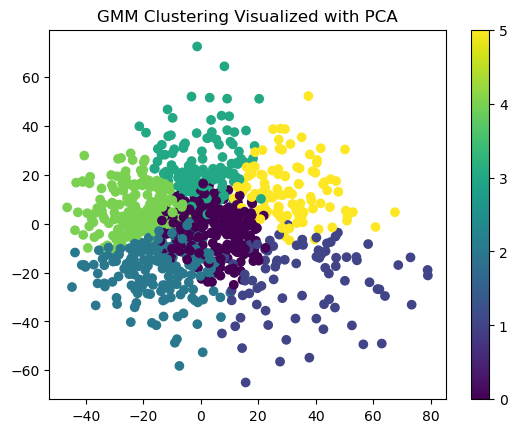

In [ ]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(audio_data)

# Apply KMeans on the original feature list
gmm = GaussianMixture(n_components=6)
clusters = gmm.fit_predict(audio_data)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('GMM Clustering Visualized with PCA')
plt.show()

___________

# Picking a Model

KMeans/MiniBatchesKMeans

In [1]:
sampled_data = bp_media.sample(n=1000, random_state=42)
sample_saved_file_paths, sample_failed_sample_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

NameError: name 'bp_media' is not defined

In [ ]:
data = bp_media.sample(n=10000, random_state=42)
saved_file_paths, failed_sample_uuids = load_audio_from_url(data, 'sample_uuid')

In [ ]:
# Initialize lists to store the track IDs, chroma features, and MFCC features
sample_track_id_list = []
sample_chroma_list = []
sample_mfcc_list = []

# Loop through each audio file and corresponding track_id
for audio_file, track_id in zip(sample_saved_file_paths, sampled_data['track_id']):  # Assuming sampled_data has 'track_id'
    try:
        # Extract Chroma and MFCC features
        chroma = extract_chroma(audio_file)  # Extract chroma features
        mfcc = extract_mfcc(audio_file)      # Extract MFCC features
        
        # Append the extracted features and track_id to their respective lists
        sample_track_id_list.append(track_id)  # Store the track_id
        sample_chroma_list.append(chroma)      # Store the chroma features
        sample_mfcc_list.append(mfcc)          # Store the MFCC features

    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        continue

In [ ]:
# Initialize lists to store the track IDs, chroma features, and MFCC features
track_id_list = []
chroma_list = []
mfcc_list = []

# Loop through each audio file and corresponding track_id
for audio_file, track_id in zip(saved_file_paths, data['track_id']):  # Assuming sampled_data has 'track_id'
    try:
        # Extract Chroma and MFCC features
        chroma = extract_chroma(audio_file)  # Extract chroma features
        mfcc = extract_mfcc(audio_file)      # Extract MFCC features
        
        # Append the extracted features and track_id to their respective lists
        track_id_list.append(track_id)  # Store the track_id
        chroma_list.append(chroma)      # Store the chroma features
        mfcc_list.append(mfcc)          # Store the MFCC features

    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        continue